# Exploratory Data Analysis
The six questions explored here are the following. The question numbers and wordings are from the module 3 assignment description, which is why they're not labeled 1-6 here. 

* 2. Which age groups are more susceptible to fraudulent transactions?
* 4. For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions
* 5. What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?
* 6. Is there a relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transactions?
* 8. What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?
* 10. Is there a relationship between between "city_pop" and incidence of fraud?

### Initial Setup and Data Engineering
Import all necessary libraries, as well as the DataEngineering class. Use the DataEngineering class to read and clean the data from the `transactions_0.csv` and `transactions_1.parquet` files. Combine the datasets into one DataFrame.

In [142]:
# Import all libraries necessary for analysis
import sys
sys.path.insert(1,'../')
from data_engineering import DataEngineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Read data from csv file and clean/prepare
csv = DataEngineering('../data/transactions_0.csv')
csv.clean_missing_values()
csv.remove_duplicates()
csv.standardize_dates('trans_date_trans_time')
csv.standardize_dates('dob')
csv.resolve_anomalous_dates('trans_date_trans_time')
csv.resolve_anomalous_dates('dob')
csv.expand_dates('trans_date_trans_time')
csv.expand_dates('dob')
csv.trim_spaces('merchant')
csv.trim_spaces('city')
csv_data = csv.get_dataset()

# Read data from parquet file and clean/prepare
parquet = DataEngineering('../data/transactions_1.parquet')
parquet.clean_missing_values()
parquet.remove_duplicates()
parquet.standardize_dates('trans_date_trans_time')
parquet.standardize_dates('dob')
parquet.resolve_anomalous_dates('trans_date_trans_time')
parquet.resolve_anomalous_dates('dob')
parquet.expand_dates('trans_date_trans_time')
parquet.expand_dates('dob')
parquet.trim_spaces('merchant')
parquet.trim_spaces('city')
parquet_data = parquet.get_dataset()

# Combine csv and parquet data into one DataFrame. Remove any duplicate transactions
data = pd.concat([csv_data, parquet_data], ignore_index=True)
data.drop_duplicates(subset=['trans_num'], inplace=True)
data.describe()

,Index,trans_date_trans_time,amt,zip,lat,long,city_pop,dob,unix_time,merch_lat,merch_long,is_fraud,day_of_week_trans_date_trans_time,hour_of_day_trans_date_trans_time,day_of_week_dob,hour_of_day_dob
count,741358.00000,741358,741358.000000,741358.000000,741358.000000,741358.000000,7.413580e+05,741358,7.413580e+05,741358.000000,741358.000000,741358.000000,741358.000000,741358.000000,741358.000000,741358.0
mean,370678.50000,2019-06-16 08:51:47.175650816,70.234214,43886.434636,38.537711,-90.215192,8.047517e+04,1966-05-06 14:37:50.740991472,1.205298e+09,38.537501,-90.215661,-0.094458,3.132787,12.809115,2.650278,0.0
min,0.00000,2019-01-01 00:00:18,1.000000,0.000000,20.027100,-165.672300,0.000000e+00,1900-01-01 00:00:00,0.000000e+00,19.029798,-166.671242,-1.000000,0.000000,0.000000,0.000000,0.0
25%,185339.25000,2019-04-06 19:01:08.750000128,9.650000,16858.000000,34.668900,-96.798000,4.710000e+02,1956-01-09 00:00:00,1.331350e+09,34.741119,-96.887798,0.000000,1.000000,7.000000,1.000000,0.0
50%,370678.50000,2019-06-20 22:45:53.500000,47.400000,43408.000000,39.354300,-87.461600,1.875000e+03,1973-05-27 00:00:00,1.338954e+09,39.367888,-87.424724,0.000000,3.000000,14.000000,2.000000,0.0
75%,556017.75000,2019-08-25 13:50:25.750000128,83.050000,68950.000000,41.894800,-80.158000,1.487100e+04,1986-01-18 00:00:00,1.345270e+09,41.954735,-80.215485,0.000000,5.000000,19.000000,4.000000,0.0
max,741357.00000,2019-11-12 22:29:09,26544.120000,99783.000000,66.693300,-67.950300,2.906700e+06,2005-01-29 00:00:00,1.352759e+09,67.510267,-66.956540,1.000000,6.000000,23.000000,6.000000,0.0
std,214011.76477,NaN,157.957813,29417.892474,5.073411,13.763146,2.896153e+05,NaN,4.027346e+08,5.107746,13.775133,0.310030,2.192725,6.816736,2.057067,0.0


### 2. Which age groups are more susceptible to fraudulent transactions?

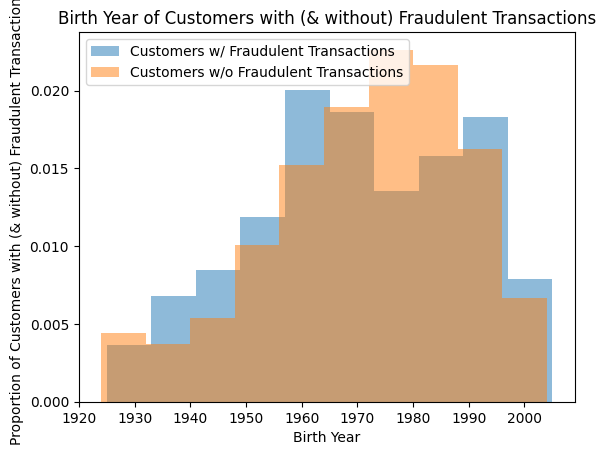

In [145]:
# Get DOB of all customers (credit card numbers) who have had at least one fraudulent transaction
fraudCustDOB = data.loc[(data['is_fraud']==1) & (data['dob'] != pd.to_datetime('1900-01-01 00:00:00')),('cc_num','dob')]
# Determine birth year
fraudCustDOB['birth_year'] = fraudCustDOB['dob'].dt.year
fraudCustDOB.drop_duplicates(inplace=True)
# Generate histogram of BirthYear of customers affected by fraud
counts, bins = np.histogram(fraudCustDOB['birth_year'])
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Customers w/ Fraudulent Transactions')
plt.title('Birth Year of Customers with (& without) Fraudulent Transactions')
plt.xlabel('Birth Year')
plt.ylabel('Proportion of Customers with (& without) Fraudulent Transactions')

# Get DOB of all customers who have never had any fraudulent transaction
noFraudCustDOB = data.loc[~data['cc_num'].isin(fraudCustDOB['cc_num']) & (data['dob'] != pd.to_datetime('1900-01-01 00:00:00')),('cc_num','dob')]
# Determine birth year
noFraudCustDOB['birth_year'] = noFraudCustDOB['dob'].dt.year
noFraudCustDOB.drop_duplicates(inplace=True)
# Generate histogram of BirthYear of customers not affected by fraud
counts, bins = np.histogram(noFraudCustDOB['birth_year'])
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Customers w/o Fraudulent Transactions')

plt.legend(loc='upper left')
plt.show()

### 4. For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions

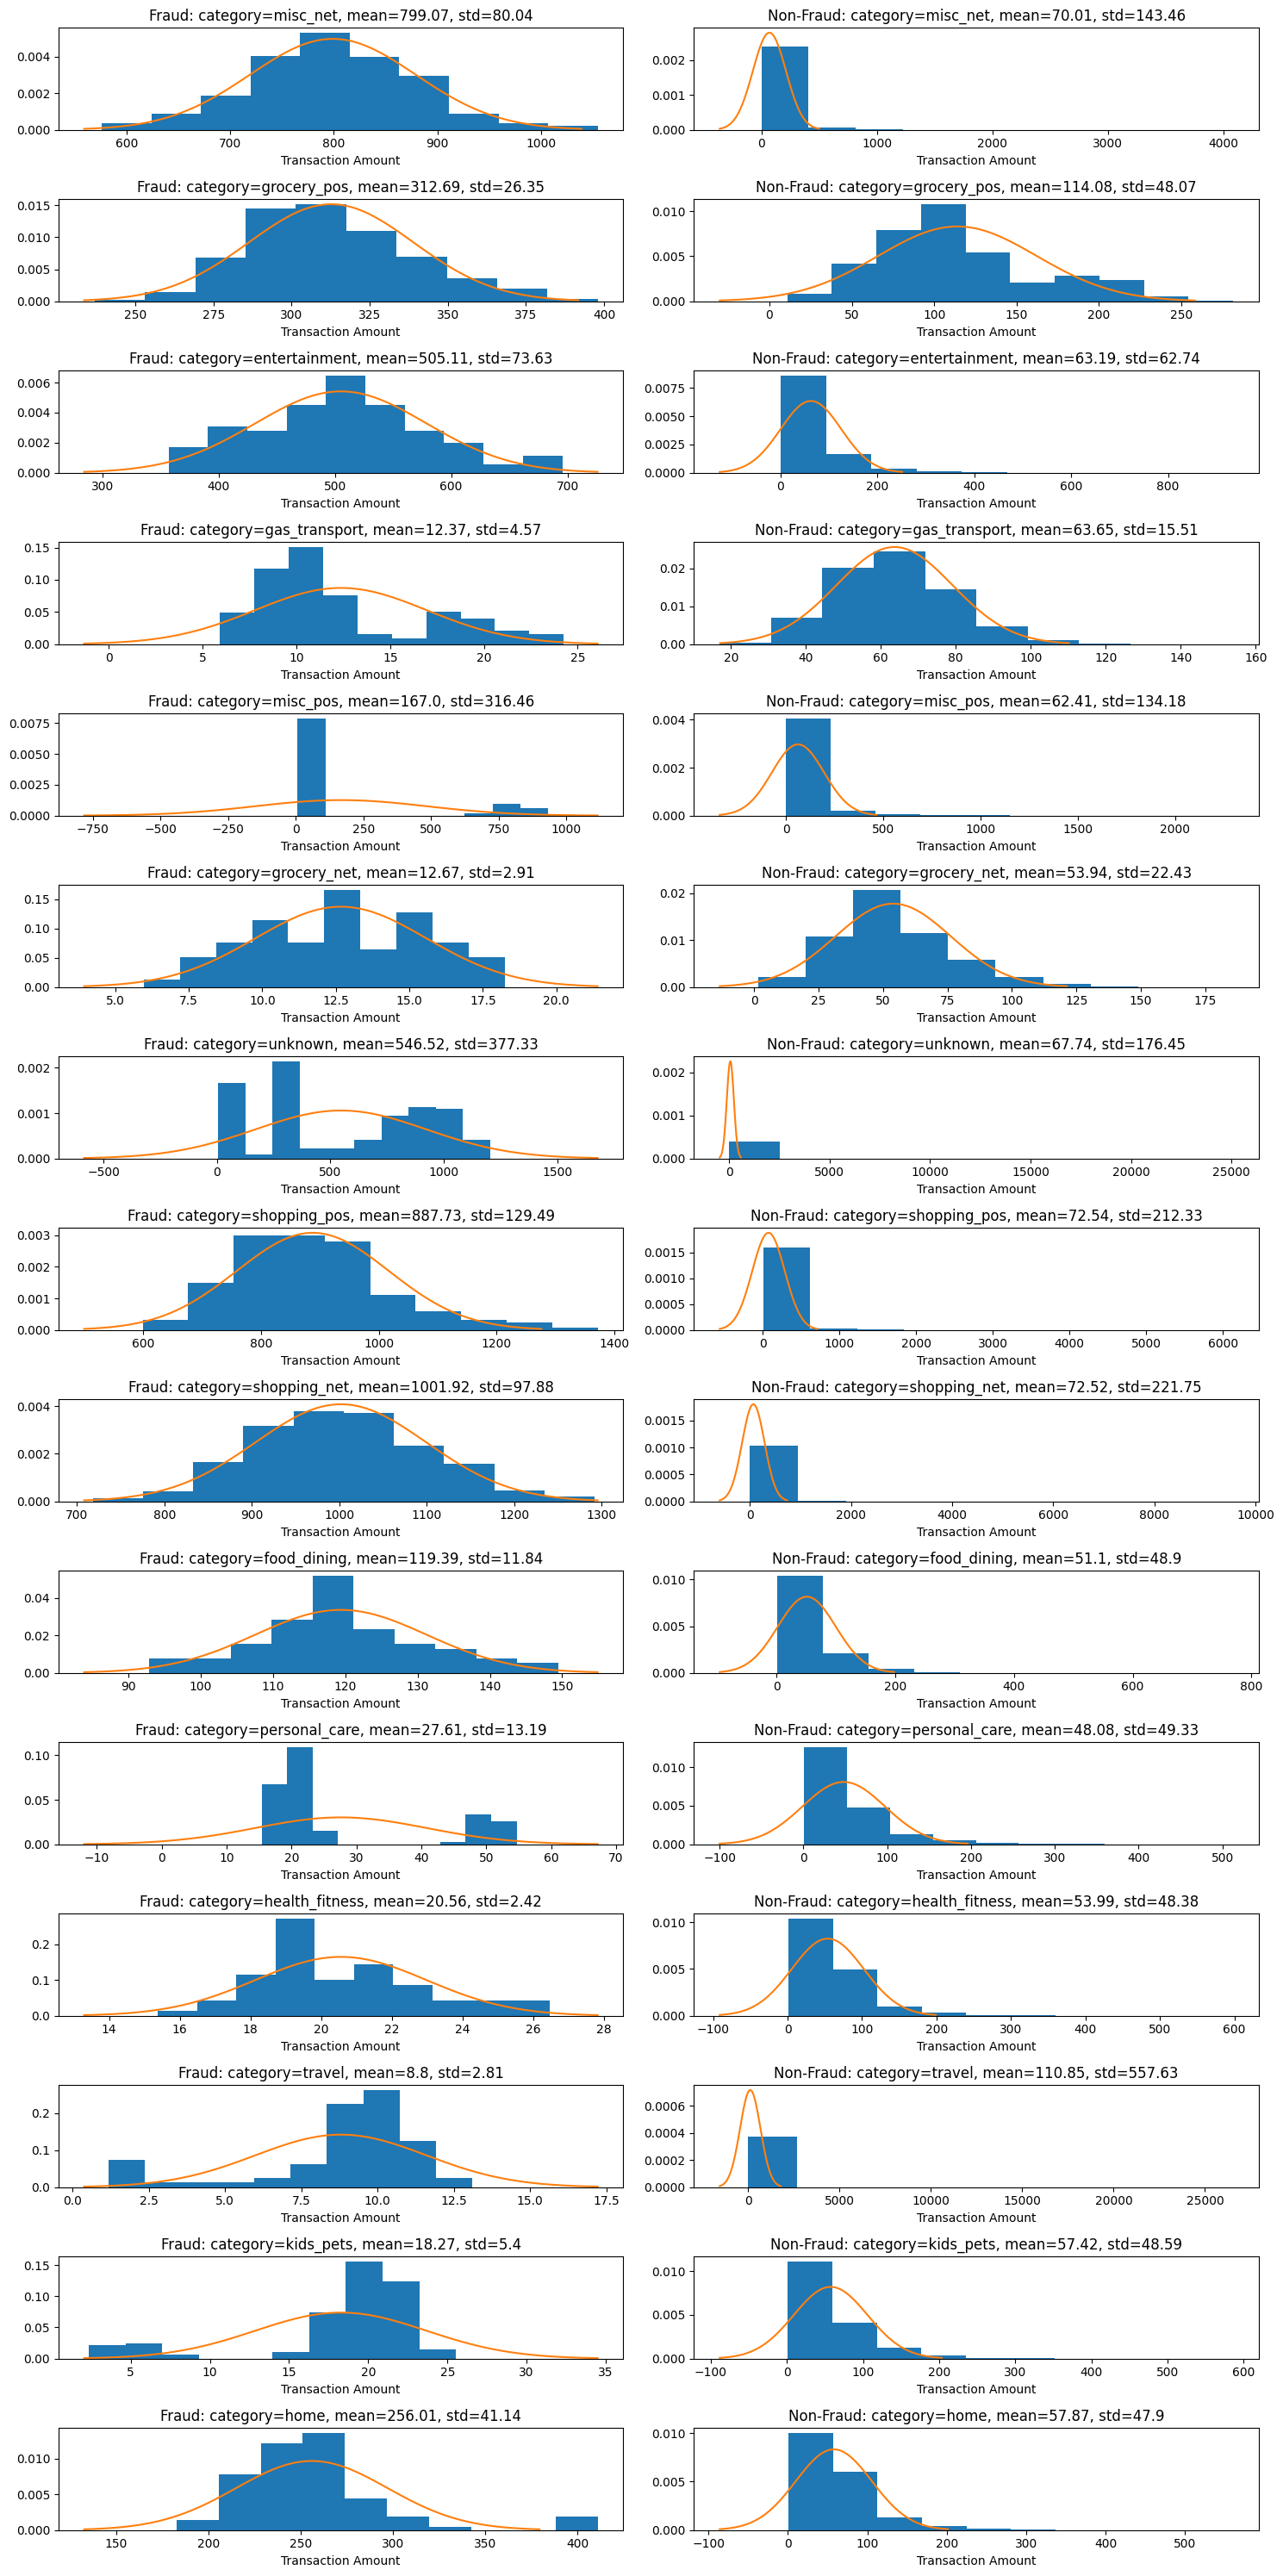

In [146]:
# Define plotting function
def plotAmtDistribution(amt, axs, row, col, category):
    # Generate histogram of BirthYear of customers not affected by fraud
    counts, bins = np.histogram(amt)
    # Normalize counts as proportions
    counts = counts / amt.shape[0]
    axs[row,col].hist(bins[:-1], bins, weights=counts, density=True)
    # Calculate mean and std
    mu = amt.mean()
    sigma = amt.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    # Plot probability density function
    axs[row,col].plot(x, scipy.stats.norm.pdf(x, mu, sigma))
    type = 'Fraud' if col == 0 else 'Non-Fraud'
    axs[row,col].set_title(f'{type}: category={category}, mean={round(mu,2)}, std={round(sigma,2)}')
    axs[row,col].set_xlabel('Transaction Amount')

# Plot distributions for each category
categories = data['category'].unique()
fig, axs = plt.subplots(len(categories),2,figsize=(15,30))
for i in range(len(categories)):
    c = categories[i]
    fraud_amt = data.loc[(data['category'] == c) & (data['is_fraud']==1), 'amt']
    noFraud_amt = data.loc[(data['category'] == c) & (data['is_fraud']==0), 'amt']
    plotAmtDistribution(fraud_amt, axs, i, 0, c)
    plotAmtDistribution(noFraud_amt, axs, i, 1, c) 

fig.tight_layout()
plt.show()


### 5. What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?

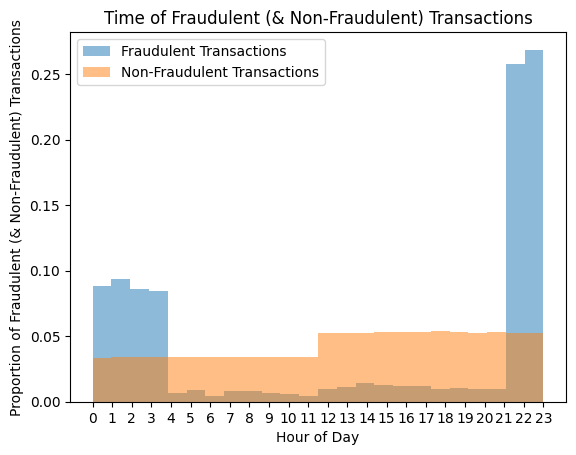

In [147]:
fraudHour = data.loc[data['is_fraud']==1,'hour_of_day_trans_date_trans_time']
counts, bins = np.histogram(fraudHour, bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Fraudulent Transactions')
plt.xticks(range(0,24,1))
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Fraudulent (& Non-Fraudulent) Transactions')
plt.title('Time of Fraudulent (& Non-Fraudulent) Transactions')

noFraudHour = data.loc[data['is_fraud']==0,'hour_of_day_trans_date_trans_time']
counts, bins = np.histogram(noFraudHour, bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5,label='Non-Fraudulent Transactions')

plt.legend(loc="upper left")
plt.show()

### 6. Is there a relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transactions?

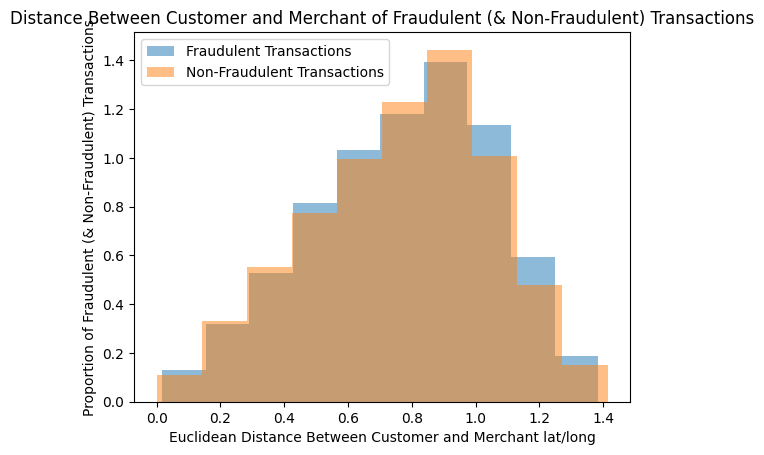

In [148]:
merchUnknownLatLongMask = (data['merch_lat']==0) & (data['merch_long'] == 0)
custUnknownLatLongMask = (data['lat'] == 0) & (data['long'] == 0)
bothLocationsKnown = ~(merchUnknownLatLongMask | custUnknownLatLongMask)
locationData = data.loc[bothLocationsKnown,('merch_lat','merch_long','lat','long','is_fraud','cc_num','merchant')]
locationData.drop_duplicates(inplace=True)
locationData['distance'] = np.linalg.norm(locationData.loc[:, ('lat','long')].values - locationData.loc[:, ('merch_lat','merch_long')], axis=1)

fraudDist = locationData.loc[locationData['is_fraud']==1,'distance']
counts, bins = np.histogram(fraudDist)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Fraudulent Transactions')

noFraudDist = locationData.loc[locationData['is_fraud']==0,'distance']
counts, bins = np.histogram(noFraudDist)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5,label='Non-Fraudulent Transactions')

plt.xlabel('Euclidean Distance Between Customer and Merchant lat/long')
plt.ylabel('Proportion of Fraudulent (& Non-Fraudulent) Transactions')
plt.title('Distance Between Customer and Merchant of Fraudulent (& Non-Fraudulent) Transactions')
plt.legend(loc="upper left")
plt.show()

### 8. What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?

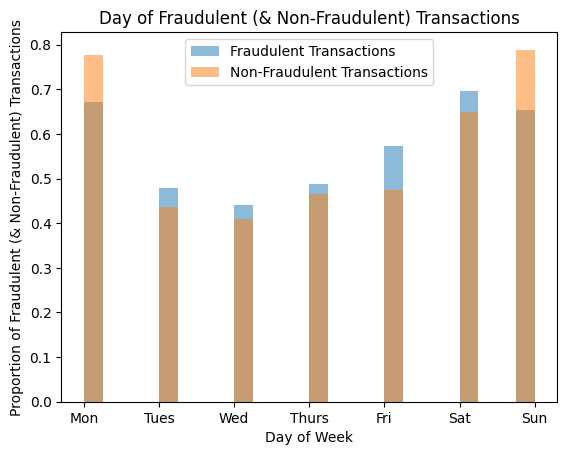

In [122]:
data['month_trans_date_trans_time'] = data['trans_date_trans_time'].dt.month
fraudDayMonth = data.loc[data['is_fraud']==1,('day_of_week_trans_date_trans_time','month_trans_date_trans_time')]
noFraudDayMonth = data.loc[data['is_fraud']==0,('day_of_week_trans_date_trans_time','month_trans_date_trans_time')]

counts, bins = np.histogram(fraudDayMonth['day_of_week_trans_date_trans_time'], bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Fraudulent Transactions')

counts, bins = np.histogram(noFraudDayMonth['day_of_week_trans_date_trans_time'], bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5,label='Non-Fraudulent Transactions')

plt.xticks(range(0,7,1), labels=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Proportion of Fraudulent (& Non-Fraudulent) Transactions')
plt.title('Day of Fraudulent (& Non-Fraudulent) Transactions')
plt.legend(loc="upper center")
plt.show()

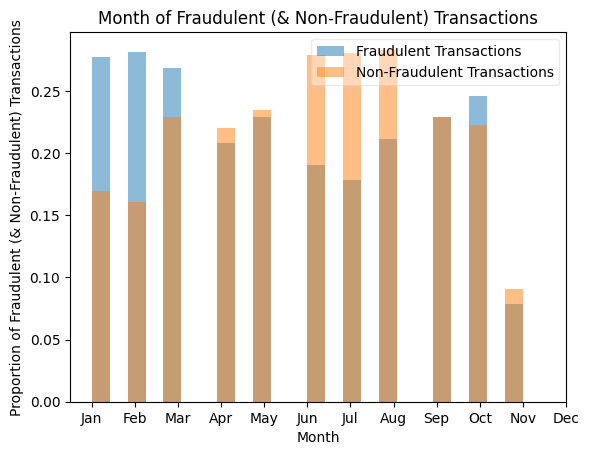

In [134]:
counts, bins = np.histogram(fraudDayMonth['month_trans_date_trans_time'], bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Fraudulent Transactions')

counts, bins = np.histogram(noFraudDayMonth['month_trans_date_trans_time'], bins=24)
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5,label='Non-Fraudulent Transactions')

plt.xticks(range(1,13,1),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Proportion of Fraudulent (& Non-Fraudulent) Transactions')
plt.title('Month of Fraudulent (& Non-Fraudulent) Transactions')
plt.legend(loc="best",framealpha=0.4)
plt.show()

### 10. Is there a relationship between between "city_pop" and incidence of fraud?

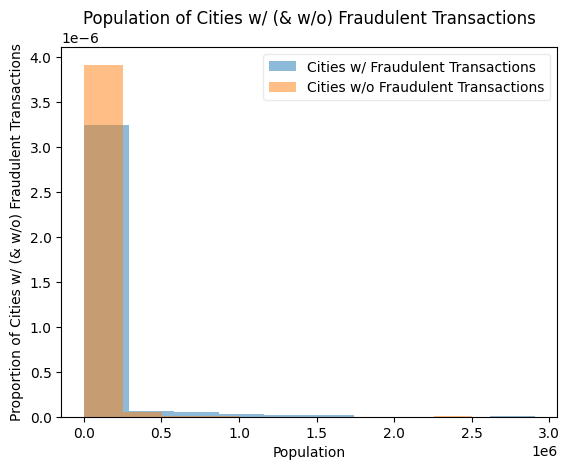

In [160]:
cityData = data.loc[:,('city','city_pop','is_fraud')]

# Find cities that have had at least 1 fraudulent transaction
fraudCity = cityData.loc[cityData['is_fraud']==1,('city','city_pop','is_fraud')]
fraudCity.drop_duplicates(inplace=True)
# Find cities that have never had any fraudulent transactions
noFraudCity = cityData.loc[~cityData['city'].isin(fraudCity['city']),('city','city_pop','is_fraud')]
noFraudCity.drop_duplicates(inplace=True)

counts, bins = np.histogram(fraudCity['city_pop'])
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5, label='Cities w/ Fraudulent Transactions')

counts, bins = np.histogram(noFraudCity['city_pop'])
plt.hist(bins[:-1], bins, weights=counts, density=True, alpha=0.5,label='Cities w/o Fraudulent Transactions')

plt.xlabel('Population')
plt.ylabel('Proportion of Cities w/ (& w/o) Fraudulent Transactions')
plt.title('Population of Cities w/ (& w/o) Fraudulent Transactions')
plt.legend(loc="best",framealpha=0.4)
plt.show()